In [1]:
#Predict the Sunrise!
#Author: Ryan Kennedy
#Purpose: Get a rudimentary introduction to data science by trying to predict the time of the sunrise.
#Special thanks to John Miner (http://craftydba.com/) for providing the data for this experiment

In [2]:
#Imports for all requisite libraries
import pandas as pd
import glob
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime

C:\Users\rkennedy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#Can be toggled on and off based on what you want to display. 
#pd.set_option('display.max_rows', 5000000)

In [4]:
#defining a function to calculate seconds from midnight
def get_sec(time_str):
    h, m = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 

def get_time(time_sec):
    converted_time = time.strftime('%H:%M', time.gmtime(time_sec))
    return converted_time

def get_mins(time_str):
    h, m = time_str.split(':')
    return int(h) * 60 + int(m) 

def get_time_from_mins(time_mins):
    time_sec = time_mins * 3600
    print(time_sec)
    converted_time = time.strftime('%H:%M', time.gmtime(time_sec))
    return converted_time

In [5]:
#Load all data into dataframe from the folder
path =r'C:\Users\rkennedy\projects\Data Science\Predict the Sunrise\SunRiseSet\SunRiseSet\outbound' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    #add year based on file name substring
    df['year']=file_[100:104]
    list_.append(df)
frame = pd.concat(list_)

In [6]:
#remove junk rows    look for value - NOTE
frame = frame.loc[frame['sunrise1'] != 'Obse']
frame=frame.dropna()

#Drop sunset data as it is irrelevant for our model.
frame = frame.drop(['sunset1'], axis=1)

In [7]:
frame['sunrise_convert']=frame['sunrise1'].apply(get_mins) #convert into minutes. split

In [8]:
frame.head()

,month1,day1,sunrise1,year,sunrise_convert
0,1,1,07:14,1993,434
1,1,2,07:14,1993,434
2,1,3,07:14,1993,434
3,1,4,07:14,1993,434
4,1,5,07:14,1993,434


In [9]:
frame.dtypes

month1              int64
day1                int64
sunrise1           object
year               object
sunrise_convert     int64
dtype: object

In [10]:
frame.describe()

,month1,day1,sunrise_convert
count,9131.000000,9131.000000,9131.000000
mean,6.523053,15.729274,338.354288
std,3.448858,8.800420,63.330044
min,1.000000,1.000000,247.000000
25%,4.000000,8.000000,278.000000
50%,7.000000,16.000000,336.000000
75%,10.000000,23.000000,399.000000
max,12.000000,31.000000,434.000000


In [11]:
#Convert columns to string to build the date column
frame['month']=frame['month1'].astype('str')
frame['day']=frame['day1'].astype('str')

frame.head()


,month1,day1,sunrise1,year,sunrise_convert,month,day
0,1,1,07:14,1993,434,1,1
1,1,2,07:14,1993,434,1,2
2,1,3,07:14,1993,434,1,3
3,1,4,07:14,1993,434,1,4
4,1,5,07:14,1993,434,1,5


In [12]:
#build the Date column by applying a lambda join function
frame['Date'] = frame[['month','day','year']].apply(lambda x:'/'.join(x), axis=1)
frame.head()

,month1,day1,sunrise1,year,sunrise_convert,month,day,Date
0,1,1,07:14,1993,434,1,1,1/1/1993
1,1,2,07:14,1993,434,1,2,1/2/1993
2,1,3,07:14,1993,434,1,3,1/3/1993
3,1,4,07:14,1993,434,1,4,1/4/1993
4,1,5,07:14,1993,434,1,5,1/5/1993


C:\Users\rkennedy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\rkennedy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


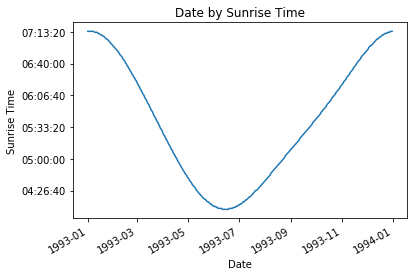

In [13]:
#plot one year of data to check out how it looks.
df=pd.DataFrame(frame)
df=frame.loc[frame["year"] == '1993']

#convert to proper datetime format
df['Date'] = pd.to_datetime(df['Date'])
df['sunrise1'] = pd.to_datetime(df['sunrise1'], format='%H:%M').dt.time

#plot
plt.plot(df["Date"],df["sunrise1"])
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Sunrise Time')
plt.title('Date by Sunrise Time')
plt.show()



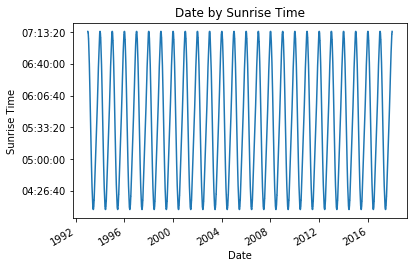

In [14]:
#convert date and plot ALL data to make sure it looks accurate
frame['Date'] = pd.to_datetime(frame['Date'])
frame['sunrise_time'] = pd.to_datetime(frame['sunrise1'], format='%H:%M').dt.time

#df
#plot
plt.plot(frame["Date"],frame["sunrise_time"])
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Sunrise Time')
plt.title('Date by Sunrise Time')
plt.show()


In [15]:
#take another look at our data frame to see what we are dealing with
frame.head()

,month1,day1,sunrise1,year,sunrise_convert,month,day,Date,sunrise_time
0,1,1,07:14,1993,434,1,1,1993-01-01,07:14:00
1,1,2,07:14,1993,434,1,2,1993-01-02,07:14:00
2,1,3,07:14,1993,434,1,3,1993-01-03,07:14:00
3,1,4,07:14,1993,434,1,4,1993-01-04,07:14:00
4,1,5,07:14,1993,434,1,5,1993-01-05,07:14:00


In [16]:
#frame.dtypes
#train_size = int(len(X) * 0.8)
#x_train, x_test = X[0:train_size], X[train_size:len(X)]
#y_train, y_test = Y[0:train_size], Y[train_size:len(Y)]
#Convert columns back to int so they can be passed into 
#frame['month']=frame['month'].astype('int')
#frame['day']=frame['day'].astype('int')

In [17]:
#Split dataframe into two, one for training and one for testing.
df_test = pd.DataFrame()
df_train = pd.DataFrame()

#We want to use 70% of our model for training, 30% for testing
df_train, df_test = np.split(frame, [int(.7*len(frame))])
df_train.head()

,month1,day1,sunrise1,year,sunrise_convert,month,day,Date,sunrise_time
0,1,1,07:14,1993,434,1,1,1993-01-01,07:14:00
1,1,2,07:14,1993,434,1,2,1993-01-02,07:14:00
2,1,3,07:14,1993,434,1,3,1993-01-03,07:14:00
3,1,4,07:14,1993,434,1,4,1993-01-04,07:14:00
4,1,5,07:14,1993,434,1,5,1993-01-05,07:14:00


In [18]:
#transform to numeric and remove junk. Might not need this.
#frame=frame.apply(pd.to_numeric, errors='coerce')
#frame=frame.dropna()

#Slice data frame into arrays to pass into the model (MORE DETAILS ON Variable names)
x_train = df_train.iloc[:,0:2].values
x_test  = df_test.iloc[:,0:2].values
y_train = df_train.iloc[:,4].values
y_test = df_test.iloc[:,4].values



#X = frame.iloc[:,0:2].values
#Y = frame.iloc[:,3].values

In [19]:
#Make sure things look correct
x_train
y_train

array([434, 434, 434, ..., 251, 251, 252], dtype=int64)

In [20]:
df_test.head()



,month1,day1,sunrise1,year,sunrise_convert,month,day,Date,sunrise_time
182,7,2,04:12,2010,252,7,2,2010-07-02,04:12:00
183,7,3,04:13,2010,253,7,3,2010-07-03,04:13:00
184,7,4,04:13,2010,253,7,4,2010-07-04,04:13:00
185,7,5,04:14,2010,254,7,5,2010-07-05,04:14:00
186,7,6,04:15,2010,255,7,6,2010-07-06,04:15:00


In [21]:
##Train the model! 
#More
model = XGBClassifier()
model.fit(x_train, y_train)
print(model)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [22]:
#Test the model on our test dataset!
y_pred = model.predict(x_test)

In [23]:
#Show raw accuracy and RMSE
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
#print("RMSE: %s" % str(datetime.timedelta(seconds=mean_squared_error(y_test, y_pred))))

#str(datetime.timedelta(seconds=666))

Accuracy: 70.07%


In [24]:
df_test.head()

,month1,day1,sunrise1,year,sunrise_convert,month,day,Date,sunrise_time
182,7,2,04:12,2010,252,7,2,2010-07-02,04:12:00
183,7,3,04:13,2010,253,7,3,2010-07-03,04:13:00
184,7,4,04:13,2010,253,7,4,2010-07-04,04:13:00
185,7,5,04:14,2010,254,7,5,2010-07-05,04:14:00
186,7,6,04:15,2010,255,7,6,2010-07-06,04:15:00


In [25]:
#frame['Date'] = pd.to_datetime(frame['Date'])
#frame['sunrise_time'] = pd.to_datetime(frame['sunrise1'], format='%H:%M').dt.time

#Build a dataframe from the predictions
df_y_pred = pd.DataFrame(y_pred, columns=['y_pred'])

#re-index both dataframes so that when we concatenate them, they stay in the proper order
df_y_pred = df_y_pred.reset_index()
df_test = df_test.reset_index()

#Add predictions column to test dataframe
df_test['prediction'] = df_y_pred['y_pred']
#df_y_pred['Date'] = df_test['Date']

#df_y_pred['y_pred']=df_y_pred['y_pred'].apply(get_time_from_Mi) #convert into minutes. split

#df_y_pred['y_pred'] = pd.to_datetime(df_y_pred['y_pred'], format='%H:%M').dt.time
#df_y_pred
df_test.head()


,index,month1,day1,sunrise1,year,sunrise_convert,month,day,Date,sunrise_time,prediction
0,182,7,2,04:12,2010,252,7,2,2010-07-02,04:12:00,252
1,183,7,3,04:13,2010,253,7,3,2010-07-03,04:13:00,253
2,184,7,4,04:13,2010,253,7,4,2010-07-04,04:13:00,253
3,185,7,5,04:14,2010,254,7,5,2010-07-05,04:14:00,254
4,186,7,6,04:15,2010,255,7,6,2010-07-06,04:15:00,255


In [26]:
df_test.head()
df_test.dtypes

index                       int64
month1                      int64
day1                        int64
sunrise1                   object
year                       object
sunrise_convert             int64
month                      object
day                        object
Date               datetime64[ns]
sunrise_time               object
prediction                  int64
dtype: object

In [27]:
#format predictions back to actual time
df_test['prediction_time']=df_test['prediction'].apply(get_time_from_mins)

df_test['prediction_time'] = pd.to_datetime(df_test['prediction_time'], format='%H:%M').dt.time
df_test.head()


907200
910800
910800
914400
918000
918000
921600
925200
925200
928800
932400
936000
936000
946800
943200
946800
950400
954000
954000
957600
961200
964800
968400
972000
975600
979200
982800
986400
990000
993600
997200
1000800
1004400
1008000
1011600
1015200
1018800
1026000
1026000
1033200
1036800
1040400
1044000
1047600
1051200
1054800
1058400
1062000
1065600
1069200
1072800
1076400
1080000
1083600
1090800
1094400
1098000
1101600
1105200
1108800
1112400
1116000
1119600
1123200
1126800
1130400
1134000
1137600
1141200
1144800
1148400
1152000
1159200
1162800
1162800
1170000
1173600
1177200
1180800
1184400
1188000
1191600
1195200
1198800
1202400
1206000
1209600
1213200
1216800
1224000
1227600
1231200
1234800
1238400
1242000
1245600
1249200
1256400
1256400
1263600
1267200
1270800
1274400
1278000
1285200
1285200
1292400
1296000
1299600
1303200
1310400
1314000
1317600
1321200
1324800
1332000
1335600
1339200
1342800
1346400
1353600
1357200
1360800
1364400
1371600
1375200
1378800
1382400
1389600

889200
889200
889200
889200
889200
889200
892800
892800
892800
892800
892800
896400
896400
896400
900000
900000
903600
903600
907200
907200
910800
910800
914400
918000
918000
921600
925200
925200
928800
932400
936000
936000
946800
943200
946800
950400
954000
954000
957600
961200
964800
968400
972000
975600
979200
982800
986400
990000
993600
997200
1000800
1004400
1008000
1011600
1015200
1018800
1026000
1026000
1033200
1036800
1040400
1044000
1047600
1051200
1054800
1058400
1062000
1065600
1069200
1072800
1076400
1080000
1083600
1090800
1094400
1098000
1101600
1105200
1108800
1112400
1116000
1119600
1123200
1126800
1130400
1134000
1137600
1141200
1144800
1148400
1152000
1159200
1162800
1162800
1170000
1173600
1177200
1180800
1184400
1188000
1191600
1195200
1198800
1202400
1206000
1209600
1213200
1216800
1224000
1227600
1231200
1234800
1238400
1242000
1245600
1249200
1256400
1256400
1263600
1267200
1270800
1274400
1278000
1285200
1285200
1292400
1296000
1299600
1303200
1310400
1314000
13

,index,month1,day1,sunrise1,year,sunrise_convert,month,day,Date,sunrise_time,prediction,prediction_time
0,182,7,2,04:12,2010,252,7,2,2010-07-02,04:12:00,252,12:00:00
1,183,7,3,04:13,2010,253,7,3,2010-07-03,04:13:00,253,13:00:00
2,184,7,4,04:13,2010,253,7,4,2010-07-04,04:13:00,253,13:00:00
3,185,7,5,04:14,2010,254,7,5,2010-07-05,04:14:00,254,14:00:00
4,186,7,6,04:15,2010,255,7,6,2010-07-06,04:15:00,255,15:00:00


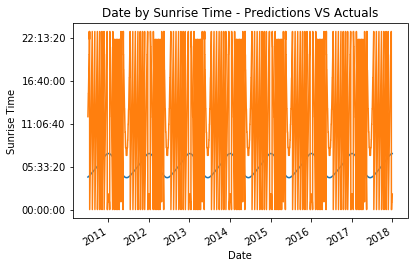

In [28]:

plt.plot(df_test["Date"], df_test["sunrise_time"], df_test["Date"], df_test["prediction_time"])

plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Sunrise Time')
plt.title('Date by Sunrise Time - Predictions VS Actuals')
plt.show()

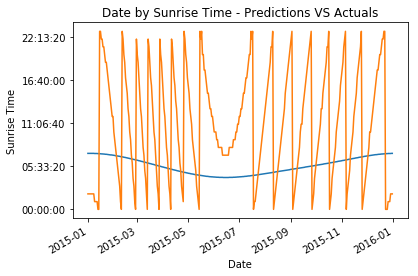

In [29]:
#Zoom in to take a closer look at just one year
subset_df = df_test[(df_test['year'] == '2015')]# & (df_test['month'] == '7')]# | (df_test['month'] == 8) | (df_test['month'] == 9) ) ]

subset_df

plt.plot(subset_df["Date"], subset_df["sunrise_time"], subset_df["Date"], subset_df["prediction_time"])

plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Sunrise Time')
plt.title('Date by Sunrise Time - Predictions VS Actuals')
plt.show()

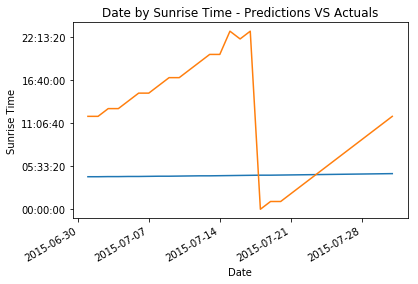

In [30]:
#Zoom in even closer to see a month
subset_df = df_test[(df_test['year'] == '2015') & (df_test['month'] == '7')]# | (df_test['month'] == 8) | (df_test['month'] == 9) ) ]

subset_df

plt.plot(subset_df["Date"], subset_df["sunrise_time"], subset_df["Date"], subset_df["prediction_time"])
plt.xlabel('Date')
plt.ylabel('Sunrise Time')
plt.title('Date by Sunrise Time - Predictions VS Actuals')
plt.gcf().autofmt_xdate()
plt.show()

In [31]:
'''
Questions:
1. When wrong, how wrong
2. Predict to minutes not seconds.
'''

'\nQuestions:\n1. When wrong, how wrong\n2. Predict to minutes not seconds.\n'

In [32]:
'''
Lessons Learned:
1. Pay attention to object types / datatypes. Machine learning models require specific data types in specific formats, so
make sure you read the model's documentation. Even something as simple as plotting a time series graph will be thrown off if your
x axis is not in the proper datetime format.
2. Indexing when merging / concatenating dataframes.  If you are trying to combine data frames, or add columns from one to
another, the index is key if you want to keep the rows in a specific order.
3. Keep in mind context of what you are predicting, and what can be considered  a 'good' model.  My raw accuracy with this model
is ~71%, but when you look at the predicted times vs the actual times, the predictions were EXTREMELY close.  In the context of
predicting the sunrise, this model would work fine.  
4. Data munging... you have heard it is most of the work, and it is true.  I had the model built and tested within an hour,
but dealing with data types / objects / munging / visualizations took a LOT longer.
5. Make sure data is accurate - shows the importance of discovery phase of data science.  My first model was abysmal, and it was 
because my source data was wrong.

70% of the time I am within at least .5 seconds of the sunrise time

'''

"\nLessons Learned:\n1. Pay attention to object types / datatypes. Machine learning models require specific data types in specific formats, so\nmake sure you read the model's documentation. Even something as simple as plotting a time series graph will be thrown off if your\nx axis is not in the proper datetime format.\n2. Indexing when merging / concatenating dataframes.  If you are trying to combine data frames, or add columns from one to\nanother, the index is key if you want to keep the rows in a specific order.\n3. Keep in mind context of what you are predicting, and what can be considered  a 'good' model.  My raw accuracy with this model\nis ~71%, but when you look at the predicted times vs the actual times, the predictions were EXTREMELY close.  In the context of\npredicting the sunrise, this model would work fine.  \n4. Data munging... you have heard it is most of the work, and it is true.  I had the model built and tested within an hour,\nbut dealing with data types / objects /